In [1]:
#Sort in order of appearance

import numpy as np
import sys
import logging
import concurrent.futures
import time
from datetime import datetime
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from pyproj import Transformer, CRS
import shapely.geometry as sg
from shapely.geometry import Polygon, Point
from sliderule import sliderule, icesat2, earthdata, h5, ipysliderule, io
import warnings
from IPython import display
import json
import utils.toolshelf as t
from random import sample
import os

import fiona

#warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
####################### SET PARAMETERS #################

## Select predetermined track (2 digit cycle number)
site = "filchnerF1"
cycle = '06'

ignoreTracks = []

## Data access options

# (-1: Skip altogether, 0: process fresh, 1: load from geojson, 2: load from csv)
accessType03 = 0
accessType06 = 0

## ATL06-SR options

# resolution (recommended 20.0)
# "len" and "res" (will be equal)
res = 10.0
cnf=2
score=50

minLength = 100

## Plot options 
### NOT YET IMPLEMENTED ###

#Plot ATL03 (0: no, 1: yes)
plot03Flag = 0

#Plot Satellite imagery flag (0: no, 1: yes)
plotImgFlag = 0

## output options

# Save flag 06 (0: dont save, 1: save as geojson (slow but everything works), 
# 2: save as csv (faster but nothing works))
sFlag06 = 0

# Save flag melange (0: dont save, 1: save as geojson)
sFlagm = 0

# Save flag 03 (0: dont save, 1: save as geojson)
sFlag03 = 0

## Some defaults for file namingd
# _save and _load is to prevent accidentally overwriting good data
# as such, freshly created data needs to be managed manually
datRoot = f"../data/IS2/"
datRoot=f"/Volumes/nox/Chance/rifts/data/IS2/"
file03_save = f"{datRoot}{site}_ATL03_cyc{cycle}_res{int(res)}"
file06_save = f"{datRoot}{site}_ATL06_cyc{cycle}_res{int(res)}"
fileMel_save = f"{datRoot}{site}_mel_cyc{cycle}_res{int(res)}"
file03_load = f"{datRoot}{site}_ATL03_res{int(res)}/{site}_ATL03_cyc{cycle}_res{int(res)}"
file06_load = f"{datRoot}{site}_ATL06_res{int(res)}/{site}_ATL06_cyc{cycle}_res{int(res)}"
fileMel_load = f"{datRoot}{site}_ATL06_melange_res{int(res)}/{site}_mel_cyc{cycle}_res{int(res)}"

In [3]:
########################### BEGIN ####################

In [4]:
# Configure ICESat-2 API
try: icesat2.init("slideruleearth.io", verbose=True)
except: print()

#Params
parms = {
    "poly": t.getRegion(site, cycle),
    "srt": 0,
    "len": res*2,
    "res": res,
    "cnf": cnf,
    "maxi": 6,
    "ats": 5.0,
    "cnt": 5,
    "H_min_win": 3.0,
    "sigma_r_max": 5.0,
    "cycle": cycle,
    "atl03_geo_fields": ['geoid', 'dem_h', 'dem_flag', 'tide_earth', 'tide_ocean', 'geoid_free2mean', 'tide_earth_free2mean'],
    # yapc photons
    #"yapc": dict(knn=0, win_h=6, win_x=11, min_ph=4, score=score)
}

In [5]:
%%time
#Triple check this cell
insufficientDataCache=[]

atl06_sr = t.get06Data(parms, file06_load=file06_load, accessType=accessType06, file06_save=file06_save, sFlag06=sFlag06, verbose=False)

# separate all good tracks and put them into a list
trackList, lens = t.getTrackList(atl06_sr, return_lens=True, omit=ignoreTracks, verbose=True, min_photons=minLength)
ss_atl06_sr = pd.concat([t.getTrack(atl06_sr, trackInfo)[0] for trackInfo in trackList])

#Geoid and Tides
ss_atl06_sr.h_mean -= ss_atl06_sr.geoid+ss_atl06_sr.tide_earth+ss_atl06_sr.tide_ocean

# Establish mélange cutoff from mean
melange_sr = ss_atl06_sr[ss_atl06_sr.h_mean<ss_atl06_sr.h_mean.mean()]

melange_trackList, melange_lens = t.getTrackList(melange_sr, return_lens=True, verbose=False, min_photons=minLength)

#new tracklist
#ss_atl06_sr_list = [t.getTrack(atl06_sr, trackInfo)[0] for trackInfo in trackList]
#t.display06Info(ss_atl06_sr)


if sFlagm==1: t.toGeojson(melange_sr, fileMel_save)

Processing new ATL06-SR dataset
Finding tracks with minimum of 100 photons
Removed 0 tracks
36 found
[734, 778, 293, 1132, 1141, 1141, 796, 876, 809, 1199, 1183, 1191, 418, 139, 162, 1143, 1150, 1145, 110, 903, 1175, 1157, 1171, 1235, 1251, 1241, 698, 1195, 1208, 1201, 1153, 1169, 1161, 491, 1120, 1131]
CPU times: user 15.4 s, sys: 184 ms, total: 15.6 s
Wall time: 22.6 s


In [6]:
on = True

if on:
    t.makeIS2Map(atl06_sr)
    t.makeIS2Map(ss_atl06_sr)
    t.makeIS2Map(melange_sr)

Map(center=[-90, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_tex…

Map(center=[-90, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_tex…

NameError: name 'melange_sr' is not defined

In [ ]:
#track, cycle, rgt, gt = t.getTrack(ss_atl06_sr, t)
#mTrack, cycle, rgt, gt = t.getTrack(melange_sr, t)

In [ ]:
# Plot method (0: random track, 1: everything)
plotMethod = 0
savePlot = False

# plot settings
yl = None#[0, 92]
xl=None
xBuffer = 0.3
yBuffer=0.1

#################################
# Plotting function
longestMel = t.getTrack(melange_sr, trackList[lens.index(max(lens))])[0]
pltWidth = (longestMel.geometry.y.max()-longestMel.geometry.y.min())*(1.0+xBuffer)
pltBuffer = (ss_atl06_sr.h_mean.max()-ss_atl06_sr.h_mean.min())*(yBuffer)
yl = [np.percentile(ss_atl06_sr.h_mean, 0.1)-pltBuffer, np.percentile(ss_atl06_sr.h_mean, 99.9)+pltBuffer]

def plot06(trackData, save=False, point='-', titl='ATL06 Data', xlab='S-N latitude', ylab='Elevation above geoid (m)',
          xBuffer=0.3, yl=None, xvar='lat'):
    track, mTrack, cycle, rgt, gt, dat = trackData[0], trackData[1], trackData[2], trackData[3], trackData[4], trackData[5]
    
    #plot the track
    fig, ax = plt.subplots(figsize=[10, 3])

    if xvar=='lat': x = track.geometry.y
    elif xvar=='dist': x = (track['distance']-track['distance'][0])/1000
    y = track.h_mean
    ax.plot(x, y, '-', color='orange', linewidth=2, label='ATL06-SR')
    ax.plot(x, y, point, color='black', linewidth=2.5)#, label='ATL06-SR')

    if xvar=='lat': x = mTrack.geometry.y
    elif xvar=='dist': x = (mTrack['distance']-mTrack['distance'][0])/1000
    y = mTrack.h_mean
    ax.plot(x, y, '.', color='red', linewidth=2.5)#, label='ATL06-SR mélange')
    ax.set_title(titl)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    avg = np.mean(track.h_mean)
    ax.set_ylim(yl)
    
    # set window
    # if there is melange, center it
    # otherwise center the entire track
    try: 
        med = np.median(mTrack.geometry.y)
        mMax = mTrack.geometry.y.max()
        mMin = mTrack.geometry.y.min()
        buffer = np.abs(mMax - mMin)*xBuffer
        ax.set_xlim([med-pltWidth/2, med+pltWidth/2])
    except:
        #print('doing the other one')
        med = np.median(track.geometry.y)
        tMax = track.geometry.y.max()
        tMin = track.geometry.y.min()
        buffer = np.abs(tMax - tMin)*xBuffer
        ax.set_xlim([tMin-buffer, tMax+buffer])
    ax.legend(loc=4, frameon=False)
    info = f'ICESat-2 track {rgt}-{t.gtDict[gt]}'
    plt.text(0.02, 0.05, info, horizontalalignment='left', verticalalignment='bottom',
             transform=ax.transAxes, fontsize=10, bbox=dict(edgecolor=None, facecolor='white', alpha=0.9, linewidth=0))
    if save:
        plt.savefig(f'{figRoot}melange/{site}_cyc{cycle}_rgt{rgt}-{t.gtDict[gt][-2:]}_res{res}_mel.png', 
                    dpi=150, bbox_inches='tight')
    
###################################    
#Plotting commands

if plotMethod==0:
    tr = sample(trackList, 1)[0]
    track, cycle, rgt, gt = t.getTrack(ss_atl06_sr, tr)
    mTrack, cycle, rgt, gt = t.getTrack(melange_sr, tr)
    dat = track.index.min().date()
    
    trackData = [track, mTrack, cycle, rgt, gt, dat]
    titl = f"{site.capitalize()}: {dat}, Cycle {cycle}, Res {res}m"
    xlab = 'S-N latitude'
    ylab = 'Elevation above geoid (m)'
    plot06(trackData, point='.', save=savePlot, titl=titl, xlab=xlab, ylab=ylab, yl=yl, xBuffer=0.3)
    
elif plotMethod==1:
    count=0
    
    for tr in trackList:
        print(f"{count}, {tr}")
        count+=1
        
        track, cycle, rgt, gt = t.getTrack(ss_atl06_sr, tr)
        mTrack, cycle, rgt, gt = t.getTrack(melange_sr, tr)
        dat = track.index.min().date()
        
        trackData = [track, mTrack, cycle, rgt, gt, dat]
        titl = f"{site.capitalize()}: {dat}, Cycle {cycle}, Res {res}m"
        xlab = 'S-N latitude'
        ylab = 'Elevation above geoid (m)'
        plot06(trackData, point='.', save=savePlot, titl=titl, xlab=xlab, ylab=ylab, yl=yl, xBuffer=0.3)
        #plt.axhline(y=60)

In [ ]:
%%time
#EarthData query to acquire granule IDs

earthdata.set_max_resources=2000
granules_list = earthdata.cmr(short_name='ATL03', polygon=t.getRegion(site, cycle), version='006', time_start=t.getDateTime(atl06_sr.index.min()), 
    time_end=t.getDateTime(atl06_sr.index.max()), return_metadata=True)
granMD = pd.DataFrame([t.unpackGranuleID(gran) for gran in granules_list[0]]).set_index('granuleID')
granule_sizes = [float(granule['granule_size']) for granule in granules_list[1]]
print(f"{len(granule_sizes)} granules with average size {np.mean(granule_sizes)/1e6} MB, totalling {np.sum(granule_sizes)/1e6/1000} GB")

In [ ]:
# ATL03 Processing

# Some track info

#atl03_yapce track from earlier (beam not selected yet)


trackID = granMD[(granMD.cycle==cycle)*(granMD.rgt==rgt)].index[0]
gtNum = int(t.gtDict[gt][2])
pair = 0 if t.gtDict[gt][3]=="l" else 1
trackID

trackInfo = (cycle, rgt, t.gtDict[gt])
track, cycle, rgt, gt = t.getTrack(ss_atl06_sr, trackInfo)
mTrack, cycle, rgt, gt = t.getTrack(melange_sr, trackInfo)

## add something to check if the data already exists

##### Set ATL03 sp parameters ##############################
parms = {
    "poly": t.getRegion(site, cycle),
    "srt": 0,
    "len": res*2,
    "res": res,
    # identify ground track
    "track": gtNum,
    # classification and checks
    # still return photon segments that fail checks
    "pass_invalid": True,
    # all photons
    #"cnf": 2,
    "cnt": 5,
    "atl03_geo_fields": ["ref_azimuth", "ref_elev", "geoid", 
        'dem_h', 'dem_flag', 'tide_earth', 'tide_ocean', 'geoid_free2mean', 'tide_earth_free2mean'],
    "atl03_ph_fields": ["delta_time", "weight_ph"],
    # all land classification flags
    "atl08_class": ["atl08_noise", "atl08_ground", "atl08_canopy", "atl08_top_of_canopy", "atl08_unclassified"],
    # all photons
    "yapc": dict(knn=0, win_h=6, win_x=11, min_ph=4, score=0), 
}

#Have a list of only one granule
gdf = icesat2.atl03sp(parms, resources=[trackID])
atl03_yapc = gdf[gdf.pair==pair]

#Geophysical corrections
atl03_yapc.height -= atl03_yapc.geoid+atl03_yapc.tide_ocean+atl03_yapc.tide_earth

# Display Statistics
t.display03Info(atl03_yapc)

if sFlag03==1:
    print(f'Saving file as geojson named {file03_save}.geojson')
    atl03_yapc.to_file(f"{file03_save}.geojson", driver='GeoJSON')
    
    
## Other stuff    
ss_atl03_yapc = t.filter_yapc(atl03_yapc, 0)
pTrack = ss_atl03_yapc
ss_atl03_yapc = atl03_yapc

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


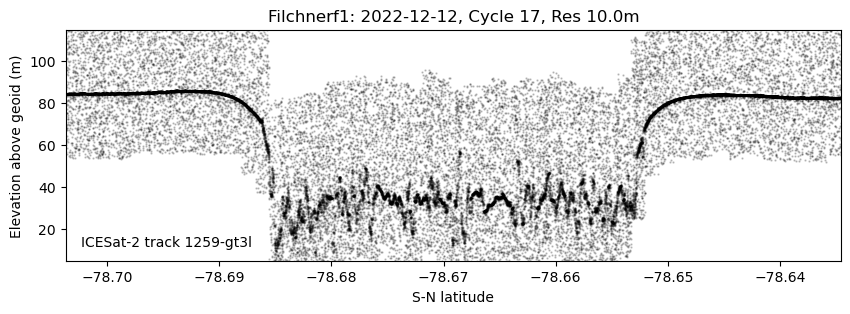

In [26]:
#Calculate plot width and set y (constant y limits)
xBuffer, yBuffer = 0.3, 0.05

longestMel = t.getTrack(melange_sr, trackList[lens.index(max(lens))])[0]
pltWidth = (longestMel.geometry.y.max()-longestMel.geometry.y.min())*(1.0+xBuffer)
pltBuffer = (ss_atl06_sr.h_mean.max()-ss_atl06_sr.h_mean.min())*(yBuffer)
#yl = [ss_atl06_sr.h_mean.min()-pltBuffer, ss_atl06_sr.h_mean.max()+pltBuffer]
#Depends on properties of the data (volume and range) and bad data will screw this up
yl = [np.percentile(ss_atl06_sr.h_mean, 1)-pltBuffer, np.percentile(ss_atl06_sr.h_mean, 99)+pltBuffer]
yl=[5, 115]

trackData = [track, mTrack, pTrack, cycle, rgt, gt, dat]
titl = f"{site.capitalize()}: {dat}, Cycle {cycle}, Res {res}m"
xlab = 'S-N latitude'
ylab = 'Elevation above geoid (m)'


def plot03(trackData, save=False, point='-', titl='ATL06 Data', xlab='S-N latitude', ylab='Elevation above geoid (m)',
          xBuffer=0.3, yl=None, xvar='lat'):
    track, mTrack, pTrack, cycle, rgt, gt, dat = trackData[0], trackData[1], trackData[2], trackData[3], trackData[4], trackData[5], trackData[6]
    
    #plot the track
    fig, ax = plt.subplots(figsize=[10, 3])
    
    ## Photons
    x = pTrack['geometry'].y
    y = pTrack.height
    c = pTrack.yapc_score
    
    plt.scatter(x, y, color='black', s=2, alpha=0.1, marker='.')#, label='ATL03-YAPC')
    
    # ATL06 points
    if xvar=='lat': x = track.geometry.y
    elif xvar=='dist': x = (track['distance']-track['distance'][0])/1000
    y = track.h_mean
    #ax.plot(x, y, '-', color='#ffb58a', linewidth=2, label='ATL06-SR')
    #ax.plot(x, y, point, color='black', linewidth=2.5)#, label='ATL06-SR')
    
    # melange
    if xvar=='lat': x = mTrack.geometry.y
    elif xvar=='dist': x = (mTrack['distance']-mTrack['distance'][0])/1000
    y = mTrack.h_mean
    #ax.plot(x, y, '.', color='red', linewidth=0.5)#, label='ATL06-SR mélange')
    #ax.scatter(x, y, '.', color='red', s=1)#, label='ATL06-SR mélange')
    
    # settings
    ax.set_title(titl)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    avg = np.mean(track.h_mean)
    ax.set_ylim(yl)
    
    # xlims
    # if there is melange, center it
    # otherwise center the entire track
    try: 
        med = np.median(mTrack.geometry.y)
        mMax = mTrack.geometry.y.max()
        mMin = mTrack.geometry.y.min()
        buffer = np.abs(mMax - mMin)*xBuffer
        ax.set_xlim([med-pltWidth/2, med+pltWidth/2])
    except:
        print('doing the other one')
        med = np.median(track.geometry.y)
        tMax = track.geometry.y.max()
        tMin = track.geometry.y.min()
        buffer = np.abs(tMax - tMin)*xBuffer
        ax.set_xlim([tMin-buffer, tMax+buffer])
    ax.legend(edgecolor='white', loc=4)
    info = f'ICESat-2 track {rgt}-{t.gtDict[gt]}'
    plt.text(0.02, 0.05, info, horizontalalignment='left', verticalalignment='bottom',
             transform=ax.transAxes, fontsize=10, bbox=dict(edgecolor=None, facecolor='white', alpha=0.9, linewidth=0))
    if save:
        plt.savefig(f'{figRoot}melange/{site}_cyc{cycle}_rgt{rgt}-{t.gtDict[gt][-2:]}_res{res}_mel.png', 
                    dpi=150, bbox_inches='tight')
        

#run for the current track        
track, cycle, rgt, gt = t.getTrack(ss_atl06_sr, tr)
mTrack, cycle, rgt, gt = t.getTrack(melange_sr, tr)
pTrack = ss_atl03_yapc

dat = track.index.min().date()

trackData = [track, mTrack, pTrack, cycle, rgt, gt, dat]
titl = f"{site.capitalize()}: {dat}, Cycle {cycle}, Res {res}m"
xlab = 'S-N latitude'
ylab = 'Elevation above geoid (m)'
plot03(trackData, point='.', save=savePlot, titl=titl, xlab=xlab, ylab=ylab, yl=yl, xBuffer=xBuffer)

In [38]:
# In progress get function for atl03

In [ ]:
'''

def get03Data(parms, trackInfo=None, file03_load=None, accessType=0, file03_save=None, sFlag03=0, verbose=False):
    
    '''
    Get ATL03 data using specified method (open .geojson, .csv, or process new using sliderule)
    If processing anew, save as .geojson or .csv if specified
    '''
    
    if accessType == 0:
        print('Processing new ATL03-SR dataset')

        # Request ATL03 Data
        atl03_yapc = icesat2.atl03p(parms)
        atl03_yapc = atl03_sr[(atl03_yapc.spot==2)+(atl03_yapc.spot==4)+(atl03_yapc.spot==6)]

        # Display Statistics 
        if verbose: t.display03Info(atl03_yapc)

        # Save all data
        if sFlag03==1:
            # save geodataframe as geojson
            print(f'Saving file as geojson named {file03_save}.geojson')
            atl03_yapc.to_file(f"{file03_save}.geojson", driver='GeoJSON')
        elif sFlag03==2:
            # Save geodataframe as csv
            print(f'Saving file as csv named {file03_save}.csv')
            atl03_yapc.to_csv(f"{file03_save}.csv")

    elif accessType==1:
        #load from geojson
        print('Downloading atl06-YAPC data upload from .geojson file')
        atl03_yapc = gpd.read_file(f"{file03_load}.geojson").set_index('time')
        if verbose: t.display03Info(atl03_yapc)
    elif accessType==2:
        # Load from csv (everything is a string)
        print('Downloading atl03-YAPC data upload from .csv file')
        atl03_yapc = gpd.read_file(f"{file03_load}.csv").set_index('time')
        if verbose: t.display03Info(atl03_yapc)
    elif accessType==-1:
        print('skipping data download altogether')
    return atl03_yapc

atl03_test = get03Data(parms, file03_load=file03_load, accessType=accessType03, file03_save=file03_save, sFlag03=sFlag03, 
            verbose=False)
            
'''

End of working code

mean geoid height -14.64599895477295 m


Text(0.02, 0.05, 'ICESat-2 track 673-gt2l')

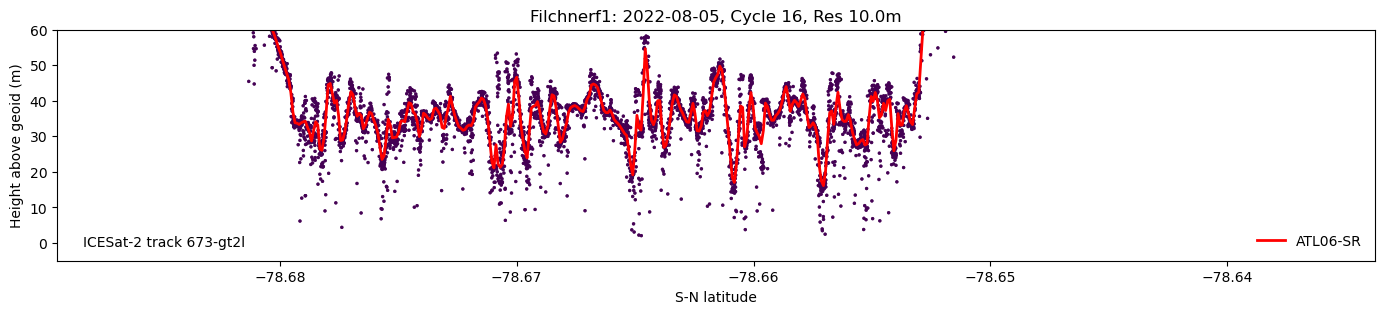

In [36]:
'''
fig, ax = plt.subplots(figsize=[17, 3])
avgGC = np.mean(atl03_yapc.geoid)
print(f'mean geoid height {avgGC} m')
x = atl03_yapc['geometry'].y
y = atl03_yapc.height-avgGC
c = atl03_yapc.yapc_score
plt.scatter(x, y, c=c, s=2, alpha=0.8)#, label='ATL03-YAPC')
x = track['geometry'].y
y = track.h_mean
if not isSeaward:
    print("Track should be reversed to seaward orientation")
    #x = (track['distance']-(track['distance'][-1]))/1000
ax.plot(x, y, '-', color='red', linewidth=2, label='ATL06-SR')
ax.set_title(titl)
ax.set_xlabel(xlab)
ax.set_ylabel(ylab)
plt.ylim(yl)
#plt.xlim([-1, 14])
ax.legend(loc=4, frameon=False)
info = f'ICESat-2 track {rgt}-{t.gtDict[gt]}'
plt.text(0.02, 0.05, info, horizontalalignment='left', verticalalignment='bottom',
         transform=ax.transAxes, fontsize=10, bbox=dict(edgecolor=None, facecolor='white', alpha=0.9, linewidth=0))
#plt.colorbar()
#plt.savefig(f'{figRoot}yapc/{site}_cyc{cycle}_rgt{rgt}-{t.gtDict[gt][-2:]}_res{res}_yapc.png', dpi=150, bbox_inches='tight')
'''

pytmd, a few meters

mean dynamic topography, 1.5 m

advection

REMA strips s79 w168 and s27 w169

In [54]:
'''
#Calculate plot width and set y (constant y limits)
longestMel = t.getTrack(melange_sr, trackList[lens.index(max(lens))])[0]
pltWidth = (longestMel.geometry.y.max()-longestMel.geometry.y.min())*(1.0+xBuffer)
pltBuffer = (ss_atl06_sr.h_mean.max()-ss_atl06_sr.h_mean.min())*(yBuffer)
yl = [ss_atl06_sr.h_mean.min()-pltBuffer, ss_atl06_sr.h_mean.max()+pltBuffer]

trackData = [track, mTrack, pTrack, cycle, rgt, gt, dat]
titl = f"{site.capitalize()}: {dat}, Cycle {cycle}, Res {res}m"
xlab = 'S-N latitude'
ylab = 'Elevation above geoid (m)'
'''

In [52]:
'''
titl = f"{site.capitalize()}: {dat}, Cycle {cycle}, Res {res}m"
xlab = 'S-N latitude'
ylab = 'Height above geoid (m)'
yl = [-5, 90]
xl = None#[-78.78, -78.72]
xw = -78.696+78.66
right = -78.66
xl = [right+xw, right]
'''

mean geoid height -14.603219032287598 m


Text(0.02, 0.05, 'ICESat-2 track 817-gt2l')

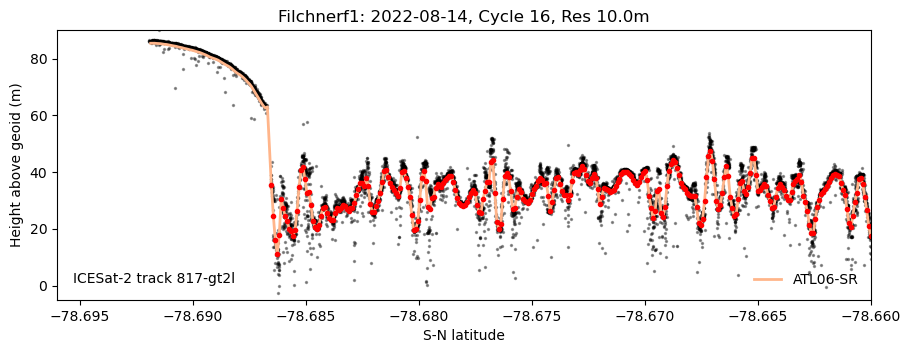

In [53]:
'''
fig, ax = plt.subplots(figsize=[10.5, 3.5])
avgGC = np.mean(atl03_yapc.geoid)
print(f'mean geoid height {avgGC} m')
x = atl03_yapc['geometry'].y
y = atl03_yapc.height-avgGC
c = atl03_yapc.yapc_score
plt.scatter(x, y, color='black', s=2, alpha=0.2)#, label='ATL03-YAPC')
x = track['geometry'].y
y = track.h_mean
if not isSeaward:
    print("Track should be reversed to seaward orientation")
    #x = (track['distance']-(track['distance'][-1]))/1000
#ax.plot(x, y, '-', color='#8a8cff', linewidth=2, label='ATL06-SR')
ax.plot(x, y, '-', color='#ffb58a', linewidth=2, label='ATL06-SR')

#x = (mTrack['distance']-track['distance'][0])/1000
x = mTrack.geometry.y
y = mTrack.h_mean
ax.plot(x, y, '.', color='red', linewidth=2.5)#, label='ATL06-SR mélange')
ax.set_title(titl)
ax.set_xlabel(xlab)
ax.set_ylabel(ylab)
plt.ylim(yl)
plt.xlim(xl)
ax.legend(loc=4, frameon=False)
info = f'ICESat-2 track {rgt}-{t.gtDict[gt]}'
plt.text(0.02, 0.05, info, horizontalalignment='left', verticalalignment='bottom',
         transform=ax.transAxes, fontsize=10, bbox=dict(edgecolor=None, facecolor='white', alpha=0.9, linewidth=0))
#plt.colorbar()
#plt.savefig(f'{figRoot}yapc/{site}_cyc{cycle}_rgt{rgt}-{t.gtDict[gt][-2:]}_res{res}_yapc.png', dpi=150, bbox_inches='tight')
'''

In [ ]:
'''
graveuard
melangeCutoffDict = {'ross1': 30, 'filchnerF1': 60, 'larsenC': 20, 'ninnis': 10}
min_photonDict = {'ross1': 200, 'filchnerF1': 200, 'larsenC': 200}
'''